#### ```Importing the necessary libraries```<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from functools import reduce
from scipy.stats import ttest_ind

#### ```Loading the dataset and splitting into Train and Test sets```<br> 
##### We have used MetaboAnalyst to find the best features for the dataset using VIP score > 1.0. The dataset is then split into Train and Test sets.

In [2]:
tumvsnat_excel_file = '../datasets/TumVsNat.xlsx'
df_dataset=pd.read_excel(tumvsnat_excel_file)
print(f"Dataset shape: {df_dataset.shape}")
df_dataset.head()

Dataset shape: (3612, 86)


,Genes,UniProtIds,P1N,P2N,P3N,P4N,P5N,P6N,P7N,P8N,...,P33T,P34T,P35T,P36T,P37T,P38T,P39T,P40T,P41T,P42T
0,Class,Class,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT,...,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor
1,A1BG,P04217,13.0551,17.5838,14.8338,16.2334,16.9404,16.7356,16.6458,16.7908,...,15.4659,14.6238,15.7534,16.196,15.0938,15.9069,15.2,15.5486,15.5263,14.8219
2,A2M,P01023,14.6325,18.7721,17.0891,17.9389,18.5565,18.5237,17.3796,18.8352,...,17.2087,17.3428,17.2272,18.7388,16.137,17.6232,16.5267,17.0701,16.8524,15.7072
3,A2ML1,A8K2U0,12.6918,11.0701,18.6586,15.5048,16.2653,15.8046,17.2486,15.9195,...,15.97,14.3276,10.9725,14.8889,13.7352,14.6385,14.51,15.8239,15.2081,14.4747
4,AAAS,Q9NRG9,13.7227,15.1066,12.9378,13.1145,14.4364,12.9498,12.9632,13.4544,...,12.4945,12.7556,13.3242,12.8469,13.5207,12.605,12.5207,12.6653,13.2007,12.6746


In [3]:
plsda_vip_csv_file = '../datasets/plsda_vip_tumvsnat.csv'
vip_df=pd.read_csv(plsda_vip_csv_file)
vip_df['avg_vip'] = vip_df.iloc[:, 1:8].mean(axis=1)
print(vip_df.shape)
vip_df.head()

(3611, 10)


,Unnamed: 0,Comp. 1,Comp. 2,Comp. 3,Comp. 4,Comp. 5,Comp. 6,Comp. 7,Comp. 8,avg_vip
0,Q03692,5.9720,5.4875,5.4280,5.3340,5.2651,5.2065,5.1793,5.1625,5.410343
1,P19013,5.7933,6.0261,5.9222,5.8483,5.7512,5.6757,5.6408,5.6208,5.808229
2,P08294,5.7093,5.3453,5.2701,5.1773,5.0938,5.0269,5.0006,4.9823,5.231900
3,P51888,5.6919,5.3145,5.2348,5.1422,5.0633,4.9977,4.9711,4.9536,5.202214
4,P20774,5.4162,5.0224,4.9540,4.8660,4.7954,4.7324,4.7099,4.6921,4.928043


In [4]:
# selecting only those rows which have avg_vip > 1
vip_df_reduced = vip_df[vip_df['avg_vip'] > 1]
print(vip_df_reduced.shape)

(894, 10)


##### We have selected only top 894  proteins based on VIP Score > 1.0. We will reduce our original dataset to only contain these top 894 proteins. We will then use this reduced dataset to train our model.

In [5]:
# Now in the original dataframe, we will select only those rows of proteins which are present in the vip_df_reduced and make the first row as header.
df_reduced=df_dataset.drop(df_dataset.columns[0], axis=1)
df_reduced.columns=df_reduced.iloc[0]
df_reduced = df_reduced[1:]
df_reduced.rename(columns={'Class': 'UniProtIds'}, inplace=True)
df_reduced = df_reduced[df_reduced['UniProtIds'].isin(vip_df_reduced['Unnamed: 0'])]
print(f"Final dataframe shape: {df_reduced.shape}")
df_reduced.head()

Final dataframe shape: (894, 85)


,UniProtIds,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT,NAT,...,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor
1,P04217,13.0551,17.5838,14.8338,16.2334,16.9404,16.7356,16.6458,16.7908,15.9421,...,15.4659,14.6238,15.7534,16.196,15.0938,15.9069,15.2,15.5486,15.5263,14.8219
2,P01023,14.6325,18.7721,17.0891,17.9389,18.5565,18.5237,17.3796,18.8352,17.257,...,17.2087,17.3428,17.2272,18.7388,16.137,17.6232,16.5267,17.0701,16.8524,15.7072
3,A8K2U0,12.6918,11.0701,18.6586,15.5048,16.2653,15.8046,17.2486,15.9195,15.5246,...,15.97,14.3276,10.9725,14.8889,13.7352,14.6385,14.51,15.8239,15.2081,14.4747
6,Q9H7C9,12.4196,15.4917,9.05751,13.6081,13.6774,12.7841,13.0361,13.7892,12.1441,...,11.2253,9.87629,12.0334,11.8365,12.4822,10.851,11.5732,11.6381,12.1437,10.5038
10,P80404,11.397,11.3531,12.1363,11.7493,12.872,12.5092,11.7592,11.1582,13.2626,...,11.7084,11.2921,11.5636,10.2072,10.6272,7.76063,10.25,8.4481,10.0645,9.50342


In [6]:
# preparing the matrix of samples vs features
df_matrix=df_reduced.T
df_matrix.reset_index(drop=True, inplace=True)
df_matrix.columns = df_matrix.iloc[0]
df_matrix = df_matrix[1:]
print(df_matrix.shape)
df_matrix.head()

(84, 894)


,P04217,P01023,A8K2U0,Q9H7C9,P80404,Q8NFV4,Q96IU4,O14639,P42765,P11310,...,P04275,P23381,Q9BZH6,Q8NI36,P47989,Q9HAV4,P49750,Q7Z739,O15231,Q86UK7
1,13.0551,14.6325,12.6918,12.4196,11.397,11.9803,13.8088,12.2385,14.5681,14.7081,...,11.597,16.567,12.2714,13.7348,12.1945,14.9267,14.2671,13.0034,14.5893,21.2164
2,17.5838,18.7721,11.0701,15.4917,11.3531,14.4096,15.2155,15.1526,18.1439,19.1649,...,14.6426,15.4928,11.2549,10.9727,10.8535,11.238,11.5224,11.7404,11.1685,23.3831
3,14.8338,17.0891,18.6586,9.05751,12.1363,12.3677,14.5616,15.6806,12.4682,13.3806,...,10.5031,13.6554,12.4031,10.9786,11.8868,13.5199,14.5906,11.8505,17.6103,19.7228
4,16.2334,17.9389,15.5048,13.6081,11.7493,11.9962,14.1772,13.5023,15.677,15.7512,...,14.2875,14.5083,11.7113,10.7884,11.1272,12.8323,13.7613,11.4506,14.8357,20.1989
5,16.9404,18.5565,16.2653,13.6774,12.872,11.925,14.2052,14.563,15.4991,16.2131,...,14.2793,14.5008,10.3292,10.4171,12.6229,11.9484,12.3084,10.472,15.4222,21.4628


In [7]:
# let us normalize the dataset using standard scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_matrix)
# replacing the original data with the scaled data
df_matrix = pd.DataFrame(scaled_data, columns=df_matrix.columns)
print(df_matrix.shape)
df_matrix.head()

(84, 894)


,P04217,P01023,A8K2U0,Q9H7C9,P80404,Q8NFV4,Q96IU4,O14639,P42765,P11310,...,P04275,P23381,Q9BZH6,Q8NI36,P47989,Q9HAV4,P49750,Q7Z739,O15231,Q86UK7
0,-2.343956,-2.394432,-0.869705,0.093619,0.177005,0.047993,0.076202,-0.680198,0.356512,-0.164932,...,-1.276071,0.812525,0.504518,2.822573,0.424959,1.608961,1.271699,1.115525,-0.238491,0.201220
1,1.354779,1.101699,-1.622961,2.270520,0.139570,2.569993,1.439011,1.562842,2.660687,2.861884,...,1.259610,0.038066,-0.318101,-0.225376,-0.071294,-1.947645,-0.949733,-0.321228,-2.341083,0.760826
2,-0.891235,-0.319691,1.901784,-2.288771,0.807419,0.450176,0.805513,1.969254,-0.996622,-1.066498,...,-2.186822,-1.286632,0.611098,-0.218865,0.311091,0.252540,1.533525,-0.195981,1.618365,-0.184541
3,0.251864,0.398014,0.436891,0.935794,0.477417,0.064500,0.433107,0.292574,1.071065,0.543485,...,0.963964,-0.671722,0.051248,-0.428749,0.029992,-0.410437,0.862328,-0.650896,-0.087041,-0.061576
4,0.829293,0.919613,0.790132,0.984900,1.434763,-0.009417,0.460234,1.109015,0.956430,0.857182,...,0.957137,-0.677130,-1.067238,-0.838475,0.583493,-1.262684,-0.313581,-1.764123,0.273451,0.264859


In [8]:
# Making a column vector of actual class labels (Tum: 1, NAT: -1)
class_labels = np.where(df_reduced.iloc[:,1:].columns.str.contains('Tumor'), 1, -1)
print(class_labels)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1]


In [9]:
# Splitting the scaled data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(df_matrix, class_labels, test_size=0.2, random_state=42)

#### ```Logistic Regression model with Elastic Net regularization```<br> 
##### Using this we will find the top 50 features.

Selected top 50 features using SelectFromModel: Index(['Q96IU4', 'P30838', 'Q9BXN1', 'P55957', 'P35613', 'Q13895', 'O75339',
       'P23946', 'Q03692', 'Q05707', 'P02461', 'Q8NBJ5', 'P15088', 'P52943',
       'Q9UBG3', 'O75718', 'Q53TN4', 'O95865', 'P07099', 'P34913', 'Q96AY3',
       'O95302', 'P29992', 'P22352', 'P07305', 'P00738', 'Q92598', 'P13646',
       'P19013', 'Q13751', 'Q9UHB6', 'Q08AI8', 'P27338', 'Q99685', 'Q99735',
       'P35749', 'O43795', 'Q8TCD5', 'P20774', 'Q6UWY5', 'P02763', 'P13674',
       'Q08174', 'P51888', 'Q13308', 'P50454', 'Q9NR46', 'P08195', 'P08294',
       'P02786'],
      dtype='object', name=0)
Mean cross-validation accuracy (Train set): 0.8494871794871796
Accuracy with top 50 features (Test set): 0.9411764705882353
Confusion Matrix:


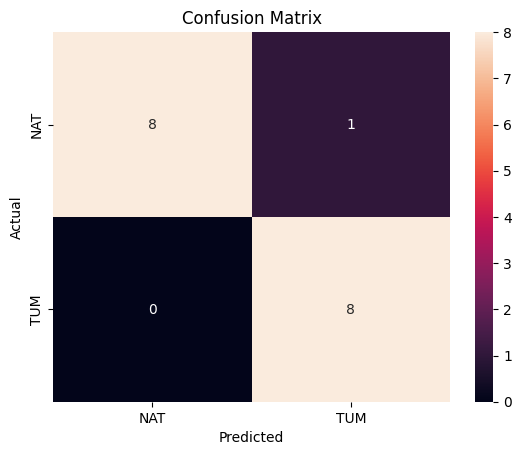

AUC: 0.9027777777777777


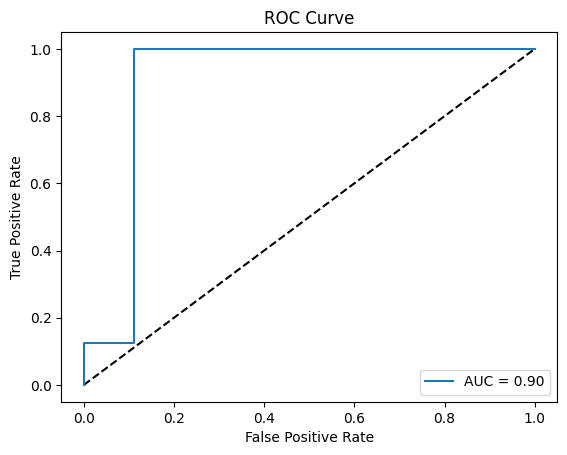

In [11]:
# The logistic regression model with Elastic Net regularization
log_reg = LogisticRegressionCV(
    Cs=10,                    # Number of different regularization strengths to try
    penalty='elasticnet',     # Elastic Net penalty
    solver='saga',            # SAGA solver supports Elastic Net
    l1_ratios=[0.1,0.5,0.9],  # Mix of L1 and L2 regularization
    cv=5,                     # 5-fold cross-validation
    max_iter=5000             # Increase max iterations
)

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Use SelectFromModel to select the top 50 features
select_model = SelectFromModel(estimator=log_reg, max_features=50)
select_model.fit(X_train, y_train)

# Get the indices of the selected features
selected_features_logreg = X_train.columns[select_model.get_support()]

# Display the top 50 features
print(f"Selected top 50 features using SelectFromModel: {selected_features_logreg}")

# Transform the dataset to only include selected features
X_train_selected = select_model.transform(X_train)
X_test_selected = select_model.transform(X_test)

# Train the model on the reduced feature set
log_reg.fit(X_train_selected, y_train)

# Print mean-cross-validation accuracy scores
print("Mean cross-validation accuracy (Train set):", np.mean(log_reg.scores_[1]))

# Make predictions on the test set using the reduced feature set
y_pred = log_reg.predict(X_test_selected)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with top 50 features (Test set): {accuracy}")

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NAT', 'TUM'], yticklabels=['NAT', 'TUM'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Get the predicted probabilities
y_pred_prob = log_reg.predict_proba(X_test_selected)[:,1]
# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### ```SVM model with Recursive Feature Elimination``` <br>
##### Using this we will find the top 50 features.

Selected top 50 features by RFE:
Index(['P01023', 'Q8NFV4', 'P98194', 'P55957', 'Q13895', 'O75339', 'P23946',
       'Q03692', 'Q9NZJ6', 'P15088', 'P52943', 'Q9UBG3', 'P34913', 'Q8TE68',
       'P11678', 'Q96AY3', 'O95302', 'P02774', 'O43708', 'P35269', 'P07305',
       'P00738', 'P00739', 'Q92598', 'P04430', 'P01703', 'Q70UQ0', 'P05161',
       'Q14624', 'P13646', 'Q2M2I5', 'Q13751', 'Q9NX58', 'Q08AI8', 'P27338',
       'Q9Y623', 'Q8TCD5', 'Q6UWY5', 'P02763', 'Q08174', 'P51178', 'P51888',
       'Q9BXM0', 'Q9UBD6', 'Q96FV2', 'P34896', 'P23497', 'Q01082', 'Q16762',
       'P09936'],
      dtype='object', name=0)
Mean cross-validation accuracy (Train set): 1.0
Accuracy with top 50 features: (Test set) 0.9411764705882353
Confusion Matrix:


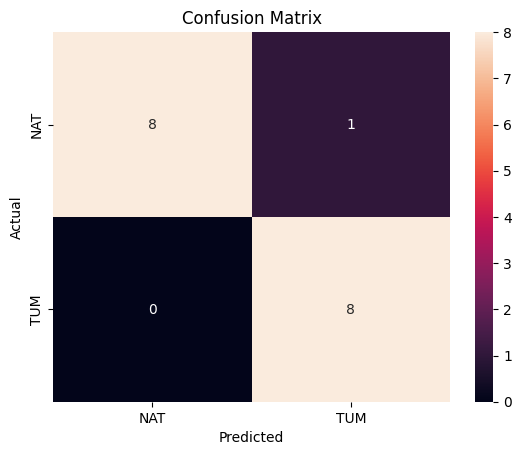

AUC: 0.8888888888888888


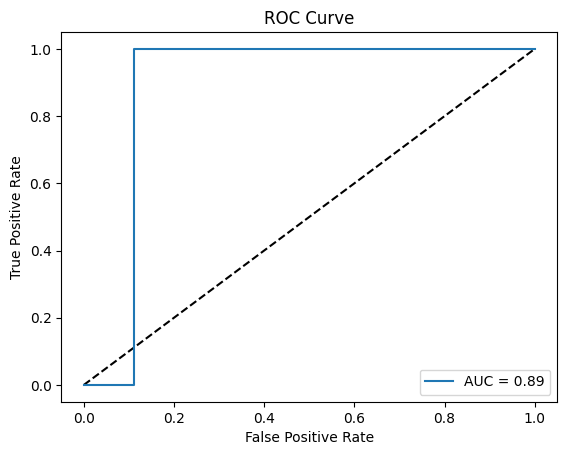

In [12]:
# The SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Apply Recursive Feature Elimination (RFE) to select top 50 features
rfe = RFE(estimator=svm_model, n_features_to_select=50, step=1)
rfe.fit(X_train, y_train)

# Get the ranking of the features and the selected features
selected_features_svm_rfe = X_train.columns[rfe.support_]
ranking = rfe.ranking_

# Display the top 50 features selected by RFE
print("Selected top 50 features by RFE:")
print(selected_features_svm_rfe)

# Make predictions using the model on the test set with the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Fit the SVM model with the selected features
svm_model.fit(X_train_selected, y_train)

# Cross-validation accuracy on the training set
cv_scores = cross_val_score(svm_model, X_train_selected, y_train, cv=5)
print("Mean cross-validation accuracy (Train set):", np.mean(cv_scores))

# Make predictions on the test set
y_pred = svm_model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with top 50 features: (Test set)", accuracy)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NAT', 'TUM'], yticklabels=['NAT', 'TUM'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Get the predicted probabilities
y_pred_prob = svm_model.decision_function(X_test_selected)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)
# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



#### ```SVM model with L1 regularization```<br>
##### We will find the top features as per L1 regularization.

Selected features by L1 regularization:
Index(['P55957', 'O75339', 'Q03692', 'Q9NZJ6', 'P52943', 'Q03001', 'P34913',
       'Q96AY3', 'P35269', 'P00738', 'Q92598', 'Q92743', 'P01876', 'P13646',
       'Q2M2I5', 'Q9NX58', 'P27338', 'Q9Y623', 'Q8TCD5', 'Q6UWY5', 'P02763',
       'Q08174', 'Q15063', 'P51888', 'Q9BXM0', 'Q9UBD6', 'Q66K66'],
      dtype='object', name=0)
Mean cross-validation accuracy (Train set): 0.9857142857142858
Accuracy with selected features by L1 (Test set): 0.9411764705882353
Confusion Matrix:


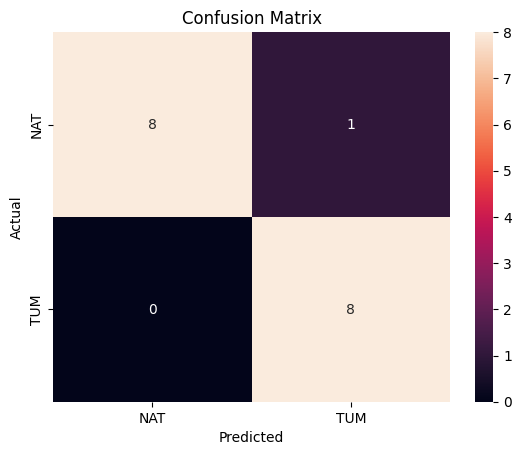

AUC: 0.8888888888888888


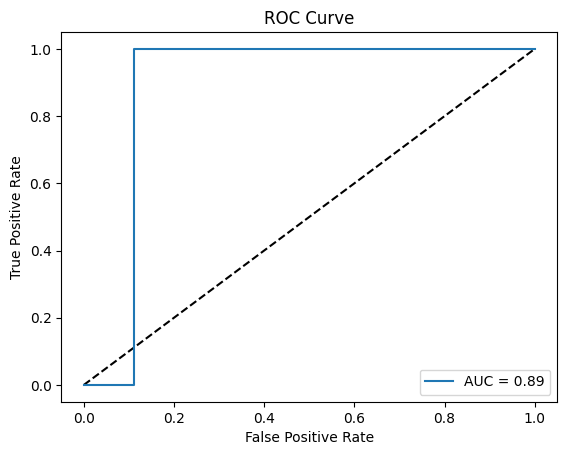

In [13]:
# The SVM model with L1 regularization and dual=False for small datasets
svm_l1_model = LinearSVC(penalty='l1', dual=False, random_state=42, max_iter=10000)

# Fit the model on the training data
svm_l1_model.fit(X_train, y_train)

# Select features with non-zero coefficients (L1 regularization performs feature selection)
selector = SelectFromModel(svm_l1_model, max_features=50, prefit=True)
X_train_selected = selector.transform(X_train.values)
X_test_selected = selector.transform(X_test.values)

# Display the selected features
selected_features_svm_l1 = X_train.columns[selector.get_support()]
print("Selected features by L1 regularization:")
print(selected_features_svm_l1)

# Cross-validation accuracy on the training set
cv_scores = cross_val_score(svm_l1_model, X_train_selected, y_train, cv=5)
print("Mean cross-validation accuracy (Train set):", np.mean(cv_scores))

svm_l1_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = svm_l1_model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features by L1 (Test set):", accuracy)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NAT', 'TUM'], yticklabels=['NAT', 'TUM'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Get the predicted probabilities
y_pred_prob = svm_l1_model.decision_function(X_test_selected)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)
# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


#### ```Random Forest Model```<br>
##### We will find the top 50 features.

Best parameters found: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Top 50 features by importance: ['P27338' 'Q13813' 'O43795' 'P08195' 'O95865' 'Q6UWY5' 'Q99735' 'P08294'
 'Q9UN36' 'Q8N335' 'Q16853' 'P00746' 'P29992' 'Q03692' 'P05166' 'Q13228'
 'Q53TN4' 'Q08J23' 'Q92598' 'O95302' 'P30086' 'P55268' 'P51888' 'Q9Y6K5'
 'P20774' 'Q9UEY8' 'Q07507' 'O14933' 'Q96AG4' 'Q16762' 'Q13509' 'P05091'
 'P13674' 'Q13308' 'O00339' 'P49189' 'P00167' 'Q9HBL0' 'P17812' 'Q9H0A0'
 'Q969V3' 'P24821' 'Q92506' 'P51608' 'Q9BX66' 'P25311' 'P32455' 'P51884'
 'P14927' 'Q63ZY3']
Mean cross-validation accuracy (Train set): 0.9703296703296704
Accuracy with top 50 features (Test set): 0.9411764705882353
Confusion Matrix:


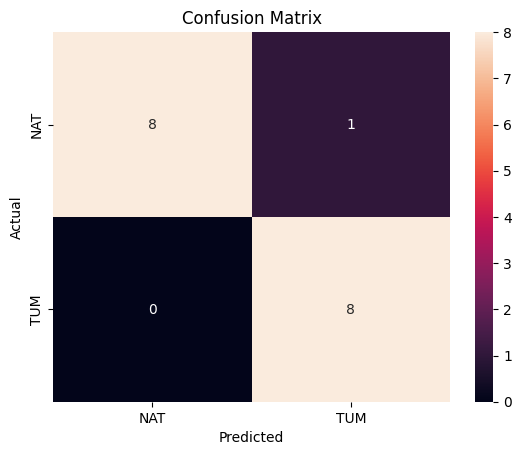

AUC: 0.9236111111111112


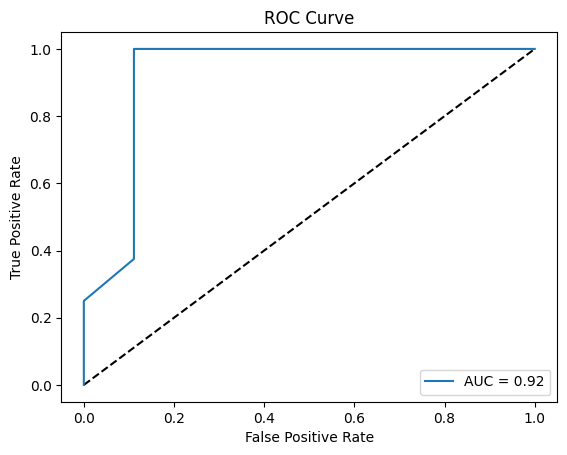

In [14]:
# The Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],   # Different numbers of trees
    'max_depth': [10, 20, None],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]    # Minimum samples required to split an internal node
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters from the grid search
print("Best parameters found:", grid_search.best_params_)

# Train Random Forest with the best parameters on the full training dataset
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Get feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame to hold feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Assuming X is a DataFrame
    'Importance': importances
})

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 50 features
selected_features_rf_op = feature_importance_df.head(50)['Feature'].values

# Print the top 50 features
print(f"Top 50 features by importance: {selected_features_rf_op}")


# Retrain the model with the modified dataset with only the top 50 features
X_train_selected = X_train[selected_features_rf_op]
X_test_selected = X_test[selected_features_rf_op]
best_rf_model.fit(X_train_selected, y_train)

# Cross-validation accuracy on the training set
cv_scores = cross_val_score(best_rf_model, X_train_selected, y_train, cv=5)
print("Mean cross-validation accuracy (Train set):", np.mean(cv_scores))

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with top 50 features (Test set):", accuracy)

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NAT', 'TUM'], yticklabels=['NAT', 'TUM'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Get the predicted probabilities
y_pred_prob = best_rf_model.predict_proba(X_test_selected)[:,1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)
# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


#### Let us take those features which are common in the top features of all the above models and use them for further analysis.

In [15]:
selected_features = [
    selected_features_logreg,
    selected_features_svm_l1,
    selected_features_rf_op
]
selected_features_names = ['selected_features_logreg', 'selected_features_svm_l1', 'selected_features_rf_op']
# A set to store the union of all common features
all_common_features = set()

# Compare each pair of feature sets
for i in range(len(selected_features)):
    for j in range(i + 1, len(selected_features)):
        common_features = set(selected_features[i]).intersection(set(selected_features[j]))
        print(f"Common features between set {selected_features_names[i]} and set {selected_features_names[j]}: {common_features}")
        all_common_features.update(common_features)

print(f"Union of all common features across all pairs: {all_common_features}")
print(f"Size of the union of all common features across all pairs: {len(all_common_features)}")

Common features between set selected_features_logreg and set selected_features_svm_l1: {'P13646', 'Q92598', 'P27338', 'O75339', 'P52943', 'Q03692', 'P34913', 'Q08174', 'P55957', 'Q6UWY5', 'P00738', 'Q8TCD5', 'Q96AY3', 'P51888', 'P02763'}
Common features between set selected_features_logreg and set selected_features_rf_op: {'P08294', 'P13674', 'Q99735', 'P27338', 'Q92598', 'Q53TN4', 'O95865', 'Q03692', 'O43795', 'O95302', 'Q6UWY5', 'P51888', 'P08195', 'Q13308', 'P20774', 'P29992'}
Common features between set selected_features_svm_l1 and set selected_features_rf_op: {'Q92598', 'P27338', 'Q03692', 'Q6UWY5', 'P51888'}
Union of all common features across all pairs: {'P13646', 'Q92598', 'P27338', 'O75339', 'P52943', 'Q03692', 'P34913', 'Q08174', 'Q96AY3', 'P08195', 'P55957', 'Q13308', 'P29992', 'P02763', 'P08294', 'P13674', 'Q99735', 'Q53TN4', 'O95865', 'O43795', 'O95302', 'Q6UWY5', 'Q8TCD5', 'P51888', 'P20774', 'P00738'}
Size of the union of all common features across all pairs: 26


In [16]:
# export the final set of features which present in all_common_features from the df_reduced 
df_all_common = df_reduced.T
df_all_common.reset_index(inplace=True)
df_all_common.columns = df_all_common.iloc[0]
df_all_common = df_all_common.iloc[1:]
df_all_common.rename(columns={'UniProtIds' : 'Class'}, inplace= True)
list_all_common = ['Class']
list_all_common.extend(list(all_common_features))
df_all_common = df_all_common[list_all_common]
print(df_all_common.shape)
df_all_common.to_excel('../results/reduced_tumvsnat_top26.xlsx', index= False)
print("Done")
df_all_common.head()

(84, 27)
Done


,Class,P13646,Q92598,P27338,O75339,P52943,Q03692,P34913,Q08174,Q96AY3,...,Q99735,Q53TN4,O95865,O43795,O95302,Q6UWY5,Q8TCD5,P51888,P20774,P00738
1,NAT,17.331,15.418,11.6678,12.932,12.8946,13.4141,9.99721,12.2044,13.667,...,15.674,12.4796,12.6958,14.1705,15.3659,12.751,12.6478,15.1116,14.8176,14.3105
2,NAT,17.9532,13.111,16.6808,16.7074,15.4751,18.9348,10.9536,11.7838,11.463,...,17.2914,15.8829,15.4235,10.9418,13.4441,15.2915,13.3769,19.494,20.0814,19.372
3,NAT,23.8924,14.1889,13.8512,14.1512,15.8005,9.88861,14.177,13.1185,9.97622,...,18.1153,13.54,14.3572,8.92645,12.8078,11.0487,13.8362,13.5809,13.8757,16.8368
4,NAT,20.6175,13.5166,14.5073,15.6171,13.7725,18.1879,12.7705,12.1858,12.9853,...,16.9488,15.3588,14.4005,12.4982,13.7583,16.1646,12.6025,18.3794,19.3332,17.6163
5,NAT,22.0085,14.0597,15.3601,17.4501,15.4238,16.1714,12.9111,14.4978,12.7325,...,17.2414,14.4952,14.4055,12.393,13.4051,16.2118,12.5089,19.5821,19.1802,18.794


In [17]:
output_file = '../results/selected_features_all_models.xlsx'
data = {
    'Logistic Regression': selected_features_logreg,
    'SVM RFE': selected_features_svm_rfe,
    'SVM L1': selected_features_svm_l1,
    'Random Forest': selected_features_rf_op
}
max_length = max(len(arr) for arr in data.values())

# Pad shorter arrays with None
for key in data:
    if len(data[key]) < max_length:
        padded_array = np.pad(data[key], (0, max_length - len(data[key])), 
                                mode='constant', constant_values=None)
        data[key] = padded_array

# Create a pandas DataFrame
df_features_all_models= pd.DataFrame(data)

# Save the DataFrame to an Excel file
df_features_all_models.to_excel(output_file, index=False)

print(f"Excel file '{output_file}' created successfully!")

Excel file '../results/selected_features_all_models.xlsx' created successfully!


In [18]:
df_common_features = pd.DataFrame(list(all_common_features), columns=['UniProtIds'])
# Export the DataFrame to an Excel file
df_common_features.to_excel('../results/top_26_common_features.xlsx', index=False)
print("Excel file 'top_26_features.xlsx' has been created with the column header 'UniProtIds'.")

Excel file 'top_26_features.xlsx' has been created with the column header 'UniProtIds'.


In [19]:
# Finding the common features between all the models
common_features = reduce(np.intersect1d, [selected_features_logreg,  selected_features_svm_l1, selected_features_rf_op])
print("Common features:", common_features)

Common features: ['P27338' 'P51888' 'Q03692' 'Q6UWY5' 'Q92598']


#### ```Trend Analysis of Common Proteins```

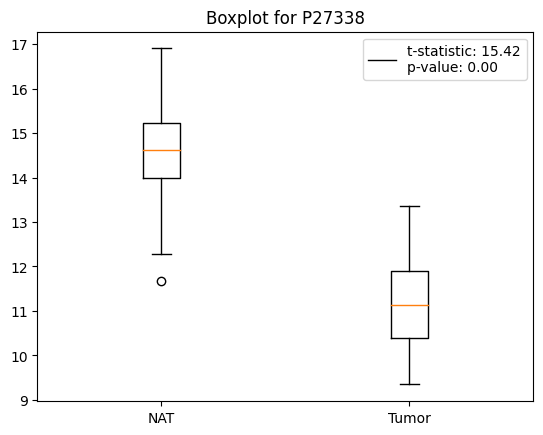

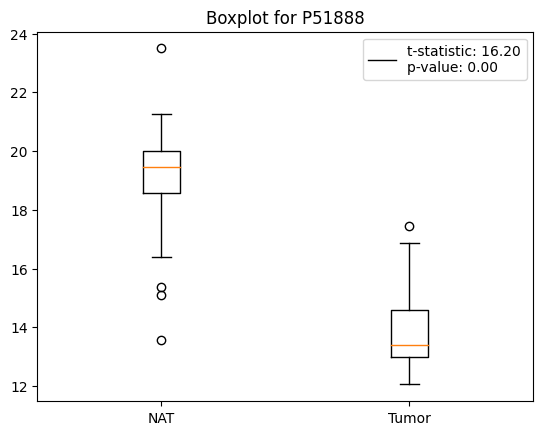

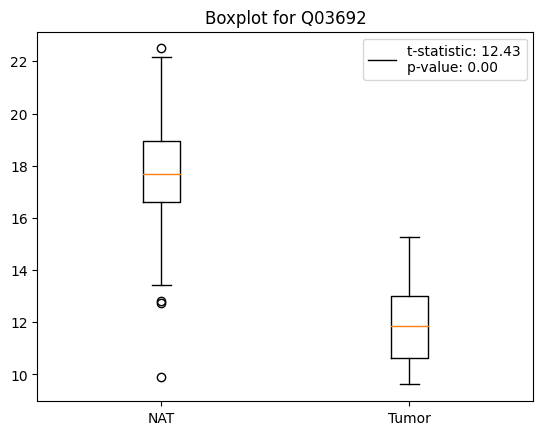

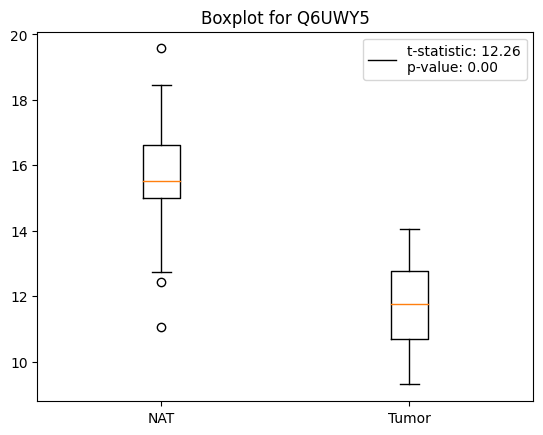

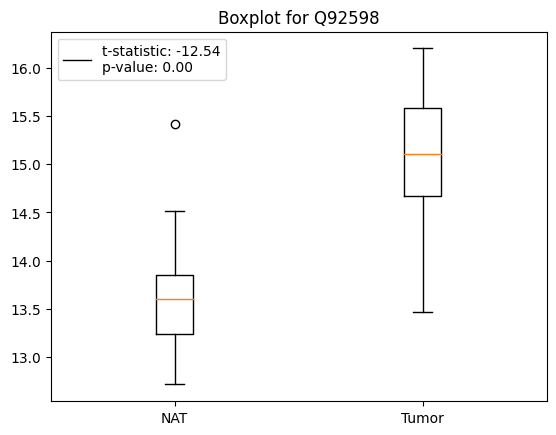

In [20]:
for i in range(len(common_features)):
    data_nat = df_all_common[common_features[i]].where(df_all_common['Class'] == 'NAT').dropna()
    data_tum = df_all_common[common_features[i]].where(df_all_common['Class'] == 'Tumor').dropna()
    # Convert data to numeric, forcing errors to NaN and then dropping them
    data_nat = pd.to_numeric(data_nat, errors='coerce').dropna()
    data_tum = pd.to_numeric(data_tum, errors='coerce').dropna()
    plt.boxplot([data_nat, data_tum])
    plt.xticks([1, 2], ['NAT', 'Tumor'])
    t_stat, p_val = ttest_ind(data_nat, data_tum)
    plt.legend(['t-statistic: {:.2f}\np-value: {:.2f}'.format(t_stat, p_val)])
    plt.title(f'Boxplot for {common_features[i]}')
    plt.show()

In [21]:
# finding the gene id of these top 5 features in the original dataframe
geneid_final= df_dataset[df_dataset['UniProtIds'].isin(common_features)].iloc[:,0].values
print(geneid_final)

['COL10A1' 'HSPH1' 'MAOB' 'OLFML1' 'PRELP']


Logistic Regression accuracy: 0.8823529411764706
AUC for Logistic Regression: 0.9027777777777777
SVM accuracy: 0.8823529411764706
AUC for SVM: 0.9166666666666666
Random Forest accuracy: 0.9411764705882353
AUC for Random Forest model: 0.9097222222222222


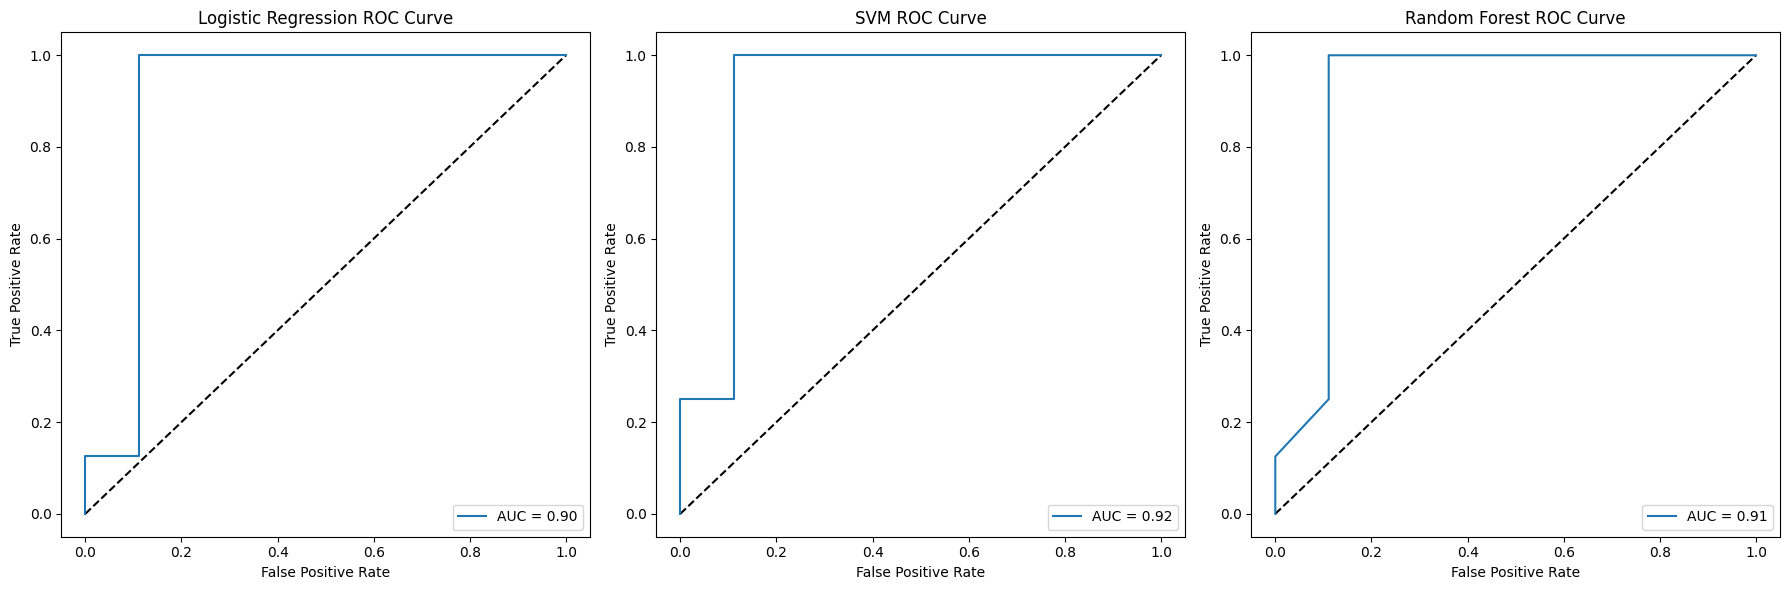

K-Nearest Neighbors accuracy: 0.9411764705882353
Naive Bayes accuracy: 0.9411764705882353


In [25]:
# Let us test all the models with the modified dataset with only the top 5 common features
X_train_selected = X_train[common_features]
X_test_selected = X_test[common_features]
# Logistic Regression
log_reg.fit(X_train_selected, y_train)
y_pred = log_reg.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression accuracy:", accuracy)

# roc curve for logistic regression
y_pred_prob = log_reg.predict_proba(X_test_selected)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
auc_logreg = roc_auc_score(y_test, y_pred_prob)
print("AUC for Logistic Regression:", auc_logreg)

# SVM
svm_model.fit(X_train_selected, y_train)
y_pred = svm_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy:", accuracy)

# roc curve for SVM
y_pred_prob = svm_model.decision_function(X_test_selected)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
auc_svm = roc_auc_score(y_test, y_pred_prob)
print("AUC for SVM:", auc_svm)

# Random Forest
best_rf_model.fit(X_train_selected, y_train)
y_pred = best_rf_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest accuracy:", accuracy)

# roc curve for Random Forest
y_pred_prob = best_rf_model.predict_proba(X_test_selected)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob)

# Calculate the AUC
auc_rf = roc_auc_score(y_test, y_pred_prob)
print("AUC for Random Forest model:", auc_rf)


# Plotting the ROC curves side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Logistic Regression ROC Curve
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].plot(fpr_log, tpr_log, label=f'AUC = {auc_logreg:.2f}')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Logistic Regression ROC Curve')
axes[0].legend()

# SVM ROC Curve
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].plot(fpr_svm, tpr_svm, label=f'AUC = {auc_svm:.2f}')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('SVM ROC Curve')
axes[1].legend()

# Random Forest ROC Curve
axes[2].plot([0, 1], [0, 1], 'k--')
axes[2].plot(fpr_rf, tpr_rf, label=f'AUC = {auc_rf:.2f}')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Random Forest ROC Curve')
axes[2].legend()

plt.tight_layout()
plt.show()

# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_selected, y_train)
y_pred = knn_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("K-Nearest Neighbors accuracy:", accuracy)

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_selected, y_train)
y_pred = nb_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Naive Bayes accuracy:", accuracy)

#### ```Validation using CPTAC dataset```<br>
##### Let us test our top features on the CPTAC data and see how well they perform.

In [22]:
cptac_tumvsnat_df=pd.read_excel('../datasets/CPTAC_TumorVsNormal.xlsx')
cptac_tumvsnat_df.columns=cptac_tumvsnat_df.iloc[0]
cptac_tumvsnat_df = cptac_tumvsnat_df[1:]
print(cptac_tumvsnat_df.shape)
cptac_tumvsnat_df.head()

(9666, 173)


,Class,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,...,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal
1,A1BG,27.735214,27.388831,27.792176,27.553753,27.495686,27.351122,28.044127,27.762844,27.949122,...,28.888463,28.561958,28.657325,29.201319,28.849308,28.194424,29.797513,28.656584,28.141711,29.482369
2,A2M,28.724642,28.33688,28.697741,29.045309,28.431308,28.415198,29.13276,29.125029,29.352481,...,29.860084,29.228258,29.575687,30.092718,30.438517,29.801524,30.786029,29.576993,30.134589,30.01899
3,A2ML1,26.751857,28.306297,26.281376,24.933444,25.209184,25.295647,25.969885,25.61233,27.065717,...,29.156701,29.171947,28.885962,29.073846,27.908045,29.302895,27.8812,29.037712,30.152118,27.01739
4,AAAS,24.348787,24.69223,24.129182,24.354724,24.389312,24.376266,24.508062,24.327592,24.148838,...,23.997952,24.005024,23.994011,23.999114,24.214862,24.313152,24.330255,24.441591,24.509601,24.45413
5,AACS,25.381833,25.582543,24.630031,25.442822,24.315146,25.054719,25.160787,24.677846,24.805092,...,25.36217,25.16681,25.375967,24.885273,24.71806,25.316458,25.365757,25.165708,25.085323,24.551569


In [23]:
# no of missing values in the cptac dataset
cptac_tumvsnat_df.isnull().sum().sum()

79213

#### `Data Imputation`<br>
##### Imputing the missing values in the cptac dataset.

In [24]:
# Separate tumor and normal samples based on column names
tumor_samples = cptac_tumvsnat_df.iloc[:, cptac_tumvsnat_df.columns.str.contains('Tumor')]
normal_samples = cptac_tumvsnat_df.iloc[:, cptac_tumvsnat_df.columns.str.contains('Normal')]

# Take transpose of the DataFrames
tumor_samples_temp = tumor_samples.T.values
normal_samples_temp = normal_samples.T.values

# Perform imputation using KNNImputer
imputer = KNNImputer(n_neighbors=5)
tumor_samples_imputed = imputer.fit_transform(tumor_samples_temp)
normal_samples_imputed = imputer.fit_transform(normal_samples_temp)

# Take transpose back after imputation
tumor_samples_imputed = tumor_samples_imputed.T
normal_samples_imputed = normal_samples_imputed.T

# Convert the numpy arrays back to DataFrames with original columns
tumor_samples_imputed = pd.DataFrame(tumor_samples_imputed, columns=tumor_samples.columns)
normal_samples_imputed = pd.DataFrame(normal_samples_imputed, columns=normal_samples.columns)

final_combined=pd.concat([tumor_samples_imputed, normal_samples_imputed], axis=1)
# replace the original data with the imputed data from column 1
cptac_tumvsnat_df.iloc[:, 1:] = final_combined
print(f'No of missing values after imputation: {cptac_tumvsnat_df.isnull().sum().sum()}')
cptac_tumvsnat_df.head()

No of missing values after imputation: 0


,Class,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,...,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal
1,A1BG,27.735214,27.388831,27.792176,27.553753,27.495686,27.351122,28.044127,27.762844,27.949122,...,28.888463,28.561958,28.657325,29.201319,28.849308,28.194424,29.797513,28.656584,28.141711,29.482369
2,A2M,28.724642,28.33688,28.697741,29.045309,28.431308,28.415198,29.13276,29.125029,29.352481,...,29.860084,29.228258,29.575687,30.092718,30.438517,29.801524,30.786029,29.576993,30.134589,30.01899
3,A2ML1,26.751857,28.306297,26.281376,24.933444,25.209184,25.295647,25.969885,25.61233,27.065717,...,29.156701,29.171947,28.885962,29.073846,27.908045,29.302895,27.8812,29.037712,30.152118,27.01739
4,AAAS,24.348787,24.69223,24.129182,24.354724,24.389312,24.376266,24.508062,24.327592,24.148838,...,23.997952,24.005024,23.994011,23.999114,24.214862,24.313152,24.330255,24.441591,24.509601,24.45413
5,AACS,25.381833,25.582543,24.630031,25.442822,24.315146,25.054719,25.160787,24.677846,24.805092,...,25.36217,25.16681,25.375967,24.885273,24.71806,25.316458,25.365757,25.165708,25.085323,24.551569


In [25]:
# saving this imputes dataset in excel file
cptac_tumvsnat_df.to_excel('../results/cptac_imputed.xlsx', index=False)
print("Done imputation.")

Done imputation.


In [26]:
df_with_top5=cptac_tumvsnat_df[cptac_tumvsnat_df['Class'].isin(geneid_final)]
print(df_with_top5.shape)
df_with_top5.head()

(5, 173)


,Class,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,Tumor,...,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal
1723,COL10A1,20.202757,20.93621,22.324609,20.955962,20.802562,21.760143,22.167604,21.943335,20.816685,...,19.573037,19.782428,19.573037,19.573037,22.764452,20.662781,19.339572,20.345242,20.458863,20.659778
3783,HSPH1,28.875757,28.493297,28.184672,28.013417,27.878915,27.75405,29.609443,27.778861,29.508005,...,27.245784,27.156901,27.256366,27.021566,27.108435,27.512416,27.159542,27.280802,27.60208,27.206671
4614,MAOB,25.518221,24.667827,24.631078,25.574976,24.953872,27.051326,24.301076,24.368287,25.376248,...,26.437114,26.920113,27.152654,26.561407,26.372552,25.988933,26.102083,25.722578,26.214201,26.187188
5717,OLFML1,24.805928,24.279228,25.128183,25.055839,25.628386,25.420186,24.633863,25.641322,25.391835,...,26.996288,26.789416,27.36642,27.138586,27.421325,26.433211,27.263742,27.217483,27.183861,26.955104
6451,PRELP,28.20972,27.495134,28.738334,28.778499,29.543571,28.99575,27.924889,29.349972,29.006227,...,30.624049,30.342099,30.438676,30.500662,30.818739,30.003559,31.307914,32.450098,31.54539,30.722864


In [27]:
labels= np.where(df_with_top5.iloc[:,1:].columns.str.contains('Tumor'), 1, -1)
print(f"class labels: {labels}")

class labels: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


In [28]:
df_with_top5_array=df_with_top5.iloc[:,1:].T.values
print(df_with_top5_array.shape)

(172, 5)


In [29]:
# split into train test 
X_train, X_test, y_train, y_test = train_test_split(df_with_top5_array, labels, test_size=0.3, random_state=42)

#### Testing with all the models that we have used in our training phase. Let us see how they perform on the validation dataset (CPTAC).

Mean cross-validation accuracy (Train set): 0.9583333333333333
Accuracy with top 5 features (Test set): 0.9615384615384616


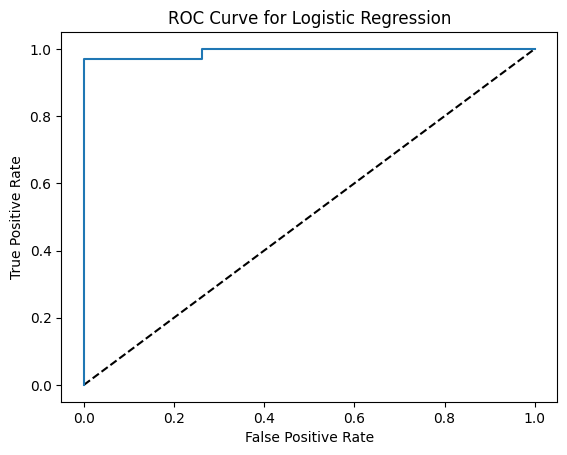

AUC: 0.9920255183413078


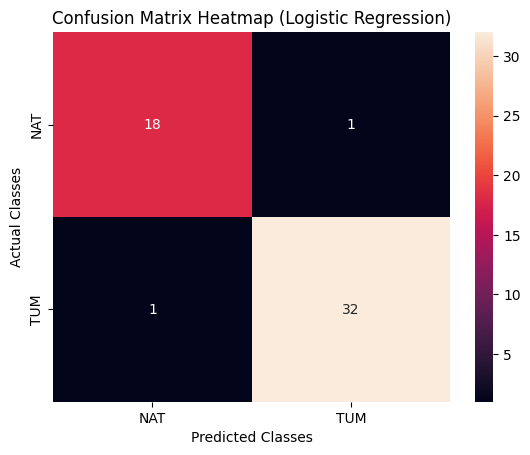

In [30]:
log_reg = LogisticRegressionCV(
    Cs=10,                    # Number of different regularization strengths to try
    penalty='elasticnet',    # Elastic Net penalty
    solver='saga',           # SAGA solver supports Elastic Net
    l1_ratios=[0.5],         # Mix of L1 and L2 regularization
    cv=5,                    # 3-fold cross-validation
    max_iter=10000            # Increase max iterations
)

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Cross-validation accuracy on the training set
cv_scores_nb = cross_val_score(log_reg, X_train, y_train, cv=5)
print("Mean cross-validation accuracy (Train set):", np.mean(cv_scores_nb))

# test on the test set
y_pred = log_reg.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with top 5 features (Test set):", accuracy)

# get the roc curve
y_pred_prob = log_reg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# plot the roc curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)


# Step 1: Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 2: Plot the heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['NAT', 'TUM'], 
            yticklabels=['NAT', 'TUM'])

plt.title('Confusion Matrix Heatmap (Logistic Regression)')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()

Mean cross-validation accuracy (Train set): 0.975
Accuracy with top 5 features (Test set): 0.9615384615384616


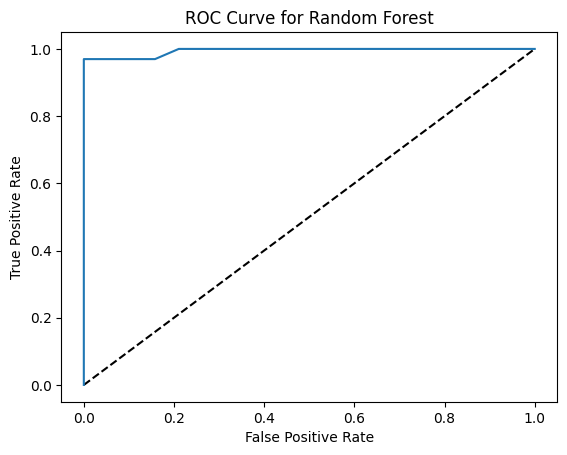

AUC: 0.9944178628389155


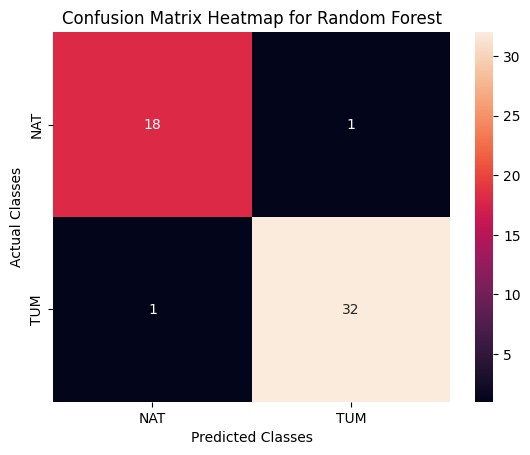

In [31]:
# Define and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Cross-validation accuracy on the training set
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Mean cross-validation accuracy (Train set):", np.mean(cv_scores))

# Optional: Make predictions and calculate accuracy
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with top 5 features (Test set):", accuracy)

# get the roc curve
y_pred_prob = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# plot the roc curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)

# Step 1: Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 2: Plot the heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=['NAT', 'TUM'], 
            yticklabels=['NAT', 'TUM'])

plt.title('Confusion Matrix Heatmap for Random Forest')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()
plt.show()

Mean cross-validation accuracy (Train set): 0.9666666666666668
Accuracy with top 5 features (Test set): 0.9807692307692307


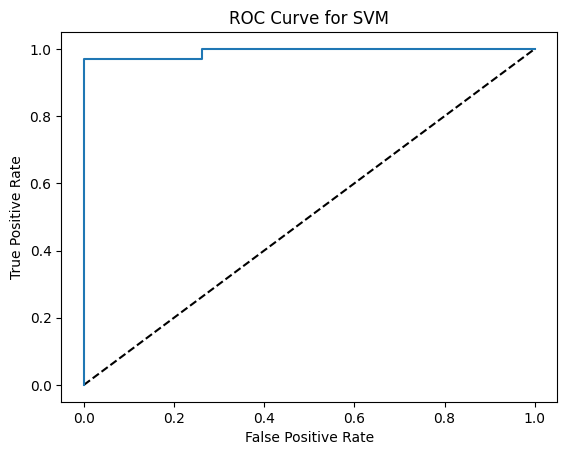

AUC: 0.9920255183413078


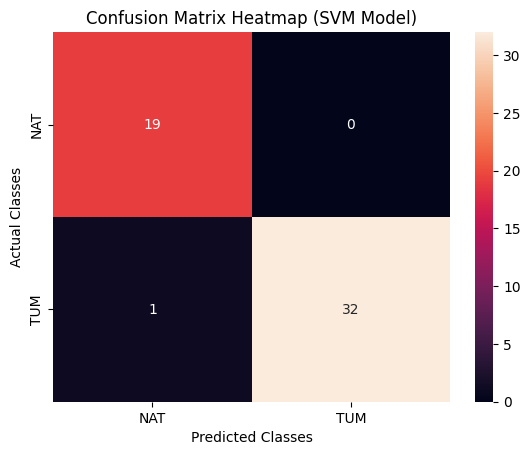

In [32]:
# do the same using svm model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Cross-validation accuracy on the training set
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print("Mean cross-validation accuracy (Train set):", np.mean(cv_scores))

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with top 5 features (Test set):", accuracy)

# get the roc curve
y_pred_prob = svm_model.decision_function(X_test)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.show()

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)

# Step 1: Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 2: Plot the heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['NAT', 'TUM'], 
            yticklabels=['NAT', 'TUM'])

plt.title('Confusion Matrix Heatmap (SVM Model)')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()